In [1]:
# 📍 STEP 1: Setup
!pip install -q pandas scikit-learn transformers textblob

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from textblob import TextBlob
import torch

In [7]:


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#STEP 2: Load dataset
file_path = '/content/drive/MyDrive/Dataset/synthetic_comparison_2000.csv'  # Update path if needed
df = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# No ID column present, but reset index just in case
df = df.reset_index(drop=True)


In [10]:
import re

def extract_cpu(spec):
    match = re.search(r'(Intel i[3579]|Ryzen [3579])', spec)
    return match.group(0) if match else None

def extract_gpu(spec):
    match = re.search(r'(RTX \d{4}|GTX \d{4}|Iris Xe|Intel UHD)', spec)
    return match.group(0) if match else None

def extract_ram(spec):
    match = re.search(r'(\d+)\s*GB\s*RAM', spec)
    return int(match.group(1)) if match else 0

def extract_ssd(spec):
    match = re.search(r'(\d+)\s*TB', spec)
    if match:
        return int(match.group(1)) * 1024
    match = re.search(r'(\d+)\s*GB\s*SSD', spec)
    return int(match.group(1)) if match else 0

# Apply parsing
df['cpu_A'] = df['specs_A'].apply(extract_cpu)
df['cpu_B'] = df['specs_B'].apply(extract_cpu)
df['gpu_A'] = df['specs_A'].apply(extract_gpu)
df['gpu_B'] = df['specs_B'].apply(extract_gpu)
df['ram_A'] = df['specs_A'].apply(extract_ram)
df['ram_B'] = df['specs_B'].apply(extract_ram)
df['ssd_A'] = df['specs_A'].apply(extract_ssd)
df['ssd_B'] = df['specs_B'].apply(extract_ssd)


In [11]:
cpu_rank = {
    'i3': 1, 'i5': 2, 'i7': 3, 'i9': 4,
    'Ryzen 3': 1, 'Ryzen 5': 2, 'Ryzen 7': 3, 'Ryzen 9': 4
}
gpu_rank = {
    'Intel UHD': 1, 'Iris Xe': 2, 'GTX 1650': 3,
    'RTX 3050': 4, 'RTX 3060': 5, 'RTX 3070': 6, 'RTX 3080': 7
}

def map_rank(val, rank_dict):
    for key in rank_dict:
        if key.lower() in str(val).lower():
            return rank_dict[key]
    return 0

df['cpu_A_score'] = df['cpu_A'].apply(lambda x: map_rank(x, cpu_rank))
df['cpu_B_score'] = df['cpu_B'].apply(lambda x: map_rank(x, cpu_rank))
df['gpu_A_score'] = df['gpu_A'].apply(lambda x: map_rank(x, gpu_rank))
df['gpu_B_score'] = df['gpu_B'].apply(lambda x: map_rank(x, gpu_rank))


In [12]:
df['cpu_diff'] = df['cpu_B_score'] - df['cpu_A_score']
df['gpu_diff'] = df['gpu_B_score'] - df['gpu_A_score']
df['ram_diff'] = df['ram_B'] - df['ram_A']
df['ssd_diff'] = df['ssd_B'] - df['ssd_A']
df['price_diff'] = df['price_B'] - df['price_A']
df['rating_diff'] = df['rating_B'] - df['rating_A']


In [13]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isnull(text): return 0
    return TextBlob(str(text)).sentiment.polarity

df['sentiment_A'] = df['reviews_A'].apply(get_sentiment)
df['sentiment_B'] = df['reviews_B'].apply(get_sentiment)
df['sentiment_diff'] = df['sentiment_B'] - df['sentiment_A']


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_to_normalize = ['ram_diff', 'ssd_diff', 'price_diff', 'rating_diff']
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


In [15]:
from sklearn.preprocessing import LabelEncoder

df['label'] = LabelEncoder().fit_transform(df['label'])  # 0 = A better, 1 = B better
structured_features = [
    'cpu_diff', 'gpu_diff', 'ram_diff', 'ssd_diff',
    'price_diff', 'rating_diff', 'sentiment_diff'
]

X_structured = df[structured_features]
y = df['label']


In [16]:
!pip install -q transformers

from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # inference mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_cls_embedding(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = bert_model(**encodings)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)


reviewA_texts = df['reviews_A'].fillna("").tolist()
reviewB_texts = df['reviews_B'].fillna("").tolist()

print("⚙️ Generating BERT embeddings for reviews_A...")
embeddings_A = get_bert_cls_embedding(reviewA_texts)

print("⚙️ Generating BERT embeddings for reviews_B...")
embeddings_B = get_bert_cls_embedding(reviewB_texts)


review_diff_tensor = embeddings_B - embeddings_A
X_text = review_diff_tensor.numpy()

print("✅ BERT embeddings and review difference computed.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

⚙️ Generating BERT embeddings for reviews_A...


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


⚙️ Generating BERT embeddings for reviews_B...


100%|██████████| 63/63 [01:06<00:00,  1.06s/it]

✅ BERT embeddings and review difference computed.


In [17]:

import numpy as np
from sklearn.model_selection import train_test_split

X_full = np.hstack([X_structured.values, X_text])  # shape: (num_samples, 7 + 768)
print(f"✅ Final input shape: {X_full.shape}  — [structured + review_diff]")


y_final = df['label'].astype(int).values  # ensure integer labels

# 📍 STEP 16: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_final, test_size=0.2, random_state=42, stratify=y_final)

print("🔹 Train size:", X_train.shape)
print("🔹 Test size :", X_test.shape)


✅ Final input shape: (2000, 775)  — [structured + review_diff]
🔹 Train size: (1600, 775)
🔹 Test size : (400, 775)


In [18]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


class ProductCompareMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = ProductCompareMLP(input_dim=X_train.shape[1]).to(device)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(5):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} ✅ Loss: {loss:.4f}")

from sklearn.metrics import accuracy_score, f1_score, classification_report

model.eval()
with torch.no_grad():
    preds_test = model(X_test_tensor.to(device)).cpu().numpy()
    preds_bin = (preds_test > 0.5).astype(int)

print("✅ Accuracy:", accuracy_score(y_test, preds_bin))
print("✅ F1 Score:", f1_score(y_test, preds_bin))
print(classification_report(y_test, preds_bin, target_names=["Product A", "Product B"]))

Epoch 1 ✅ Loss: 0.6842
Epoch 2 ✅ Loss: 0.6683
Epoch 3 ✅ Loss: 0.6649
Epoch 4 ✅ Loss: 0.6611
Epoch 5 ✅ Loss: 0.6570
✅ Accuracy: 0.615
✅ F1 Score: 0.7586206896551724
              precision    recall  f1-score   support

   Product A       0.67      0.03      0.05       156
   Product B       0.61      0.99      0.76       244

    accuracy                           0.61       400
   macro avg       0.64      0.51      0.40       400
weighted avg       0.63      0.61      0.48       400



In [21]:
!pip install -q xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

mlp_probs = model(X_test_tensor.to(device)).detach().cpu().numpy().flatten()
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

ensemble_probs = (mlp_probs + xgb_probs) / 2
ensemble_preds = (ensemble_probs > 0.5).astype(int)

print("✅ Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("✅ Ensemble F1 Score:", f1_score(y_test, ensemble_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:14:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble Accuracy: 0.9625
✅ Ensemble F1 Score: 0.968944099378882


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 📍 Device & Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

train_losses = []

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(5):
    loss = train_epoch(model, train_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch+1} ✅ Loss: {loss:.4f}")

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

model.eval()
with torch.no_grad():
    mlp_probs = model(X_test_tensor.to(device)).cpu().numpy().flatten()
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
ensemble_probs = (mlp_probs + xgb_probs) / 2
ensemble_preds = (ensemble_probs > 0.5).astype(int)

#Evaluation Metrics
acc = accuracy_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
auc = roc_auc_score(y_test, ensemble_probs)

print(f"\n✅ Ensemble Evaluation:")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC Score      : {auc:.4f}\n")
print(classification_report(y_test, ensemble_preds, target_names=["Product A", "Product B"]))

Epoch 1 ✅ Loss: 0.7080
Epoch 2 ✅ Loss: 0.6930
Epoch 3 ✅ Loss: 0.6827
Epoch 4 ✅ Loss: 0.6707
Epoch 5 ✅ Loss: 0.6578

✅ Ensemble Evaluation:
Accuracy       : 0.9700
Precision      : 0.9789
Recall         : 0.9707
F1 Score       : 0.9748
AUC Score      : 0.9881

              precision    recall  f1-score   support

   Product A       0.96      0.97      0.96       161
   Product B       0.98      0.97      0.97       239

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:17:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


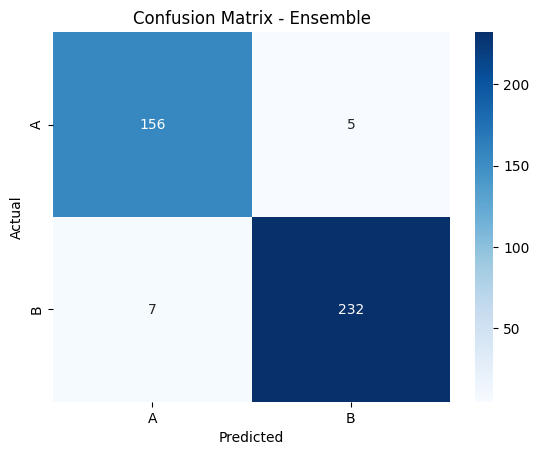

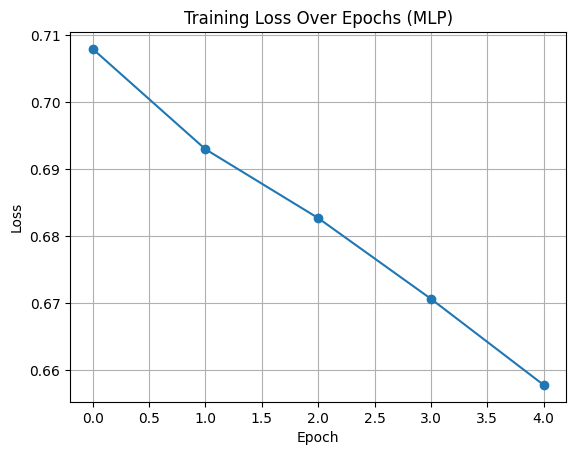

In [24]:
#Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble")
plt.show()



📍 Epoch 1: Loss = 0.6442, Accuracy = 0.6619
📍 Epoch 2: Loss = 0.6311, Accuracy = 0.6706
📍 Epoch 3: Loss = 0.6160, Accuracy = 0.6837
📍 Epoch 4: Loss = 0.6037, Accuracy = 0.6731
📍 Epoch 5: Loss = 0.5878, Accuracy = 0.7044
📍 Epoch 6: Loss = 0.5738, Accuracy = 0.6950
📍 Epoch 7: Loss = 0.5636, Accuracy = 0.7231
📍 Epoch 8: Loss = 0.5474, Accuracy = 0.7206
📍 Epoch 9: Loss = 0.5324, Accuracy = 0.7388
📍 Epoch 10: Loss = 0.5207, Accuracy = 0.7438


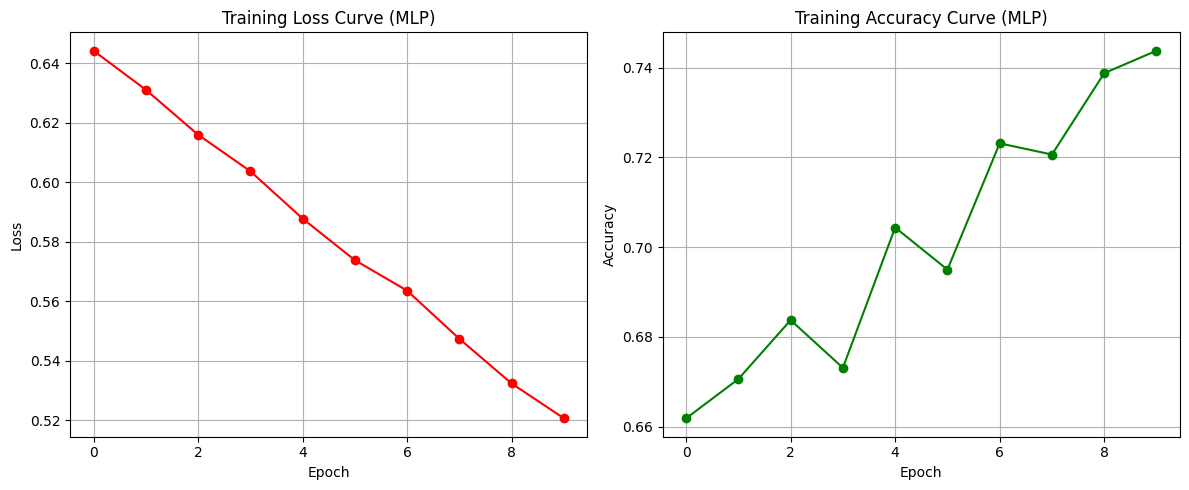

In [25]:
# STEP: Enhanced Training Loop with Accuracy Tracking
train_losses = []
train_accuracies = []

def train_epoch_with_accuracy(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (preds > 0.5).float()
        correct += (predicted == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Run the Training Loop
for epoch in range(10):
    loss, acc = train_epoch_with_accuracy(model, train_loader)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"📍 Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


# Plot Training Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='red')
plt.title("Training Loss Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Training Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



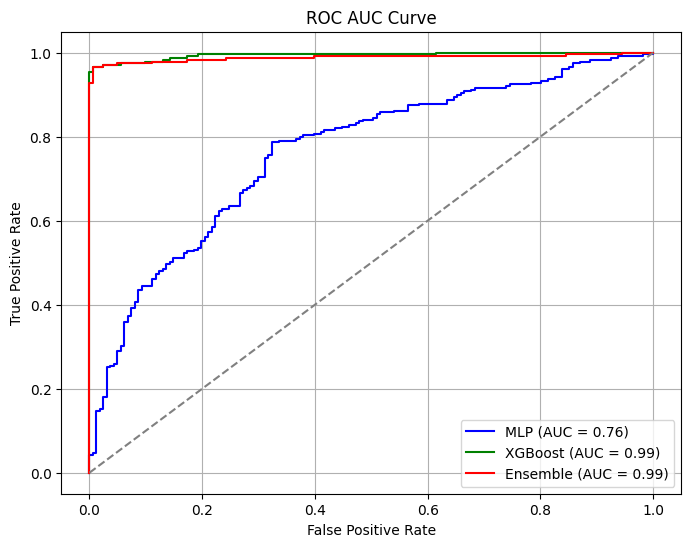

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ⚙️ Compute ROC curve and AUC for MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ⚙️ Compute ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# ⚙️ Compute ROC curve and AUC for Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_probs)
roc_auc_ens = auc(fpr_ens, tpr_ens)

#Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {roc_auc_mlp:.2f})", color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", color='green')
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC = {roc_auc_ens:.2f})", color='red')

#Diagonal line for random guess
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Train Accuracy: 0.72125
Test Accuracy: 0.97
Train Loss: 0.5169198142061656
Test Loss: 0.2530849611985511


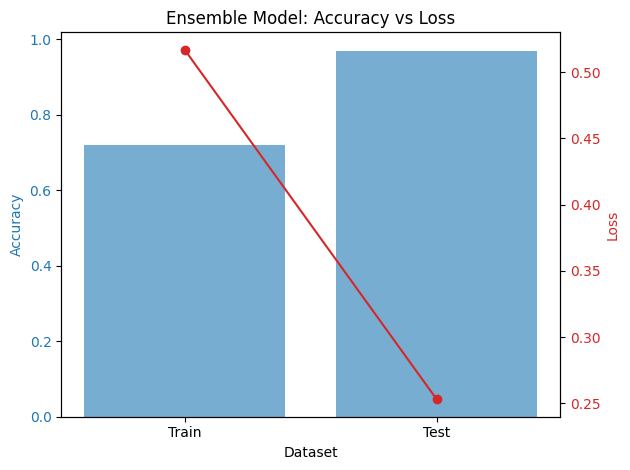

In [31]:
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

# Ensemble probabilities: average of XGBoost and MLP
ensemble_train_probs = (xgb_model.predict_proba(X_train)[:, 1] + model(X_train_tensor.to(device)).detach().cpu().numpy().ravel()) / 2
ensemble_test_probs = (xgb_probs + model(X_test_tensor.to(device)).detach().cpu().numpy().ravel()) / 2

# Convert probabilities to class predictions (threshold = 0.5)
ensemble_train_preds = (ensemble_train_probs >= 0.5).astype(int)
ensemble_test_preds = (ensemble_test_probs >= 0.5).astype(int)

# Accuracy
train_accuracy = accuracy_score(y_train, ensemble_train_preds)
test_accuracy = accuracy_score(y_test, ensemble_test_preds)

# Log loss
train_loss = log_loss(y_train, ensemble_train_probs)
test_loss = log_loss(y_test, ensemble_test_probs)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Plotting Accuracy vs Loss
fig, ax1 = plt.subplots()

# Primary y-axis (Accuracy)
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color='tab:blue', alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis (Loss)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(['Train', 'Test'], [train_loss, test_loss], color='tab:red', marker='o', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Ensemble Model: Accuracy vs Loss')
fig.tight_layout()
plt.show()